<h1 style="font-size:30px;">Managing Custom Data Using:</h1>  

### `tf.data.Dataset` and `image_dataset_from_directory()`

Until now, we have been using datasets that can be directly loaded from TensorFlow modules (e.g., tf.keras.datasets). This is a very convenient way to get started, but ultimately you will need to learn how to use your own data or data that you download from various resources on the internet. This means learning about the utilities in TensorFlow and Keras that can help you efficiently manage local datasets that may be in a variety of formats. 

This notebook will introduce a utility class in Keras called **`image_dataset_from_directory()`** that provides a lot of flexibility for handling local datasets that reside on your filesystem. We will demonstrate how to use it in an end-to-end example, from exploring a dataset to training a model to make predictions. We have already covered many of these steps in previous notebooks, but we will now be working with new object types associated with the data. Therefore, you will need to get familiar with the syntax and various optional arguments that provide the flexibility for managing your data.

<img src='https://opencv.org/wp-content/uploads/2022/03/c4_03_balls_dataset_images_structure.png' width=750 align='center'><br/>

## Table of Contents
* [1 Keras Image_Dataset_From_Directory()](#1-Keras-Image_Dataset_From_Directory())
* [2 Dataset Exploration [Kaggle: Types of Balls]](#2-Dataset-Exploration-[Kaggle:-Types-of-Balls])
* [3 Using image_dataset_from_directory](#3-Using-image_dataset_from_directory)
* [4 Train a Deep Neural Network Model](#4-Train-a-Deep-Neural-Network-Model)
* [5 Model Evaluation](#5-Model-Evaluation)
* [6 Conclusion](#6-Conclusion)

## 1 Keras `Image_Dataset_From_Directory()`

Keras features the utility function <a href="https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory" target=_blank>image_dataset_from_directory</a>, which lets you quickly set up a data pipeline that can automatically turn image files on disk into batches of preprocessed tensors. Calling **`image_dataset_from_directory(directory)`** will first list the subdirectories of the directory and assume each one contains images from one of our classes. It will then index the image files in each subdirectory. Finally, it will create and return a **`BatchDataset`** object (which is a sub-class of **`tf.data.Dataset`**), configured to read these files, shuffle them, decode them to tensors, resize them to a shared size, and pack them into batches.

```python
tf.keras.utils.image_dataset_from_directory(directory, 
                                            labels='inferred', 
                                            label_mode='int',
                                            class_names=None, 
                                            color_mode='rgb', 
                                            batch_size=32, 
                                            image_size=(256, 256), 
                                            shuffle=True, 
                                            seed=None, 
                                            validation_split=None, 
                                            subset=None,
                                            interpolation='bilinear', 
                                            follow_links=False,
                                            crop_to_aspect_ratio=False, **kwargs)
```

In [ ]:
import os
import tensorflow as tf
import glob as glob
import matplotlib.pyplot as plt
import random
import numpy as np
from dataclasses import dataclass  
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers

plt.rcParams['figure.figsize'] = (12, 9)
block_plot = False

# Fix seeds for reproducibility.
SEED_VALUE = 42
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE) 

## 2 Dataset Exploration [Kaggle: Types of Balls]

To illustrate the use of a custom dataset, we will use a dataset from Kaggle that contains <a href="https://www.kaggle.com/gpiosenka/balls-image-classification" target=_blank>Type of Balls</a>. The original dataset from Kaggle contains images of 2860 balls from 24 classes. However, we will use a smaller version of the dataset that contains ten classes. Several samples are shown below. The smaller version of the dataset will automatically be downloaded and extracted in the next code block. 

<!-- <img src='./visuals/c4_03_balls_dataset_images.png' width=1000 align='center'><br/> -->

### 2.1 Download and Extract the Dataset

In [ ]:
import requests

def download_file(url, save_name):
    url = url
    file = requests.get(url)

    open(save_name, 'wb').write(file.content)
    
download_file('https://www.dropbox.com/s/6nrjxr2ycnpcy63/dataset_balls.zip?dl=1', 'dataset_balls.zip')

In [ ]:
import zipfile

zip_file = 'dataset_balls.zip'
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall("./")
        print("Extracted all")
except:
    print("Invalid file")

Extracted all


### 2.2 Dataset Directory Structure
Let's take a look at how the images and folders are structured. This will be of particular importance when using 
`image_dataset_from_directory()`. There are two top-level directories called `train` and `valid` and each of these contains subdirectories for each of the classes in the dataset. Each of the class subfolders in turn, contains the images for the respective classes. Not all datasets are conveniently split into train and validation components, but we will see in the next notebook that `image_dataset_from_directory()` has the flexibilty to split the data into train and validation components if required.

```
├── train
│   ├── baseball
│   ├── basketball
│   ├── beachballs
│   ├── billiard ball
│   ├── bowling ball
│   ├── brass
│   ├── buckeyballs
│   ├── cannon ball
│   ├── cricket ball
│   └── eyeballs
└── valid
    ├── baseball
    ├── basketball
    ├── beachballs
    ├── billiard ball
    ├── bowling ball
    ├── brass
    ├── buckeyballs
    ├── cannon ball
    ├── cricket ball
    └── eyeballs

```

### <font style="color:rgb(50,120,230)">Print classes</font>
Here we will access the class names by simply navigating the filesystem in the dataset directly. Further below we will show you how you can access these class names using the `BatchDataset` object.

In [ ]:
# Class names.
class_names = sorted([f for f in os.listdir('./dataset_balls/train') if not f.startswith('.')])

for i in range(len(class_names)):
    print(i, class_names[i])

0 baseball
1 basketball
2 beachballs
3 billiard ball
4 bowling ball
5 brass
6 buckeyballs
7 cannon ball
8 cricket ball
9 eyeballs


### 2.3 Dataset Visualization

Let's start by exploring the image data using conventional methods.

In [ ]:
def get_all_image_paths(dir_path):

    # Retrieve all the images paths.
    image_paths = glob.glob(f"{dir_path}/train/*/*", recursive=True)
    return image_paths

In [ ]:
def display_dataset_samples(image_paths):

    plt.figure(figsize=(18, 12))
    num_rows = 5
    num_cols = 8
    for i in range(num_rows*num_cols):
        plt.subplot(num_rows, num_cols, i+1)
        
        # Generate a random index.
        random_idx = random.choice(list(range(0, len(image_paths))))
        image = plt.imread(image_paths[random_idx])
        label = image_paths[random_idx].split('/')[-2]
        plt.imshow(image)
        plt.axis('off')
        plt.title(label)
        
    plt.show(block=block_plot)

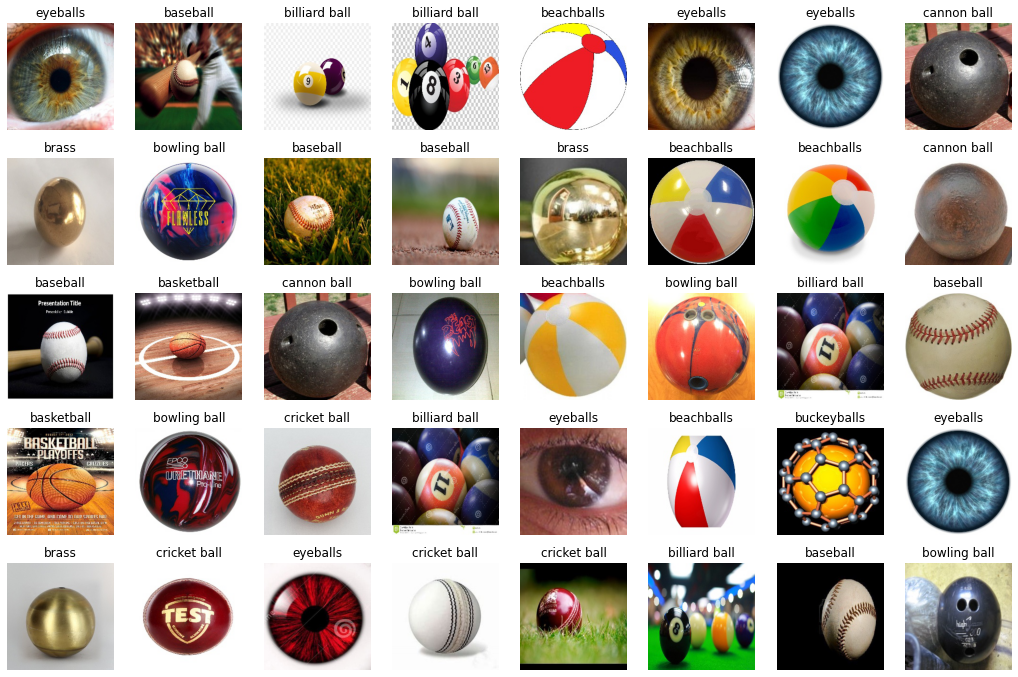

In [ ]:
# Get all the image paths.
image_paths = get_all_image_paths('./dataset_balls')

# Display several random images from the dataset.
display_dataset_samples(image_paths)

## 3 Using `image_dataset_from_directory`
### 3.1 Set data configuration parameters

In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES:  int = 10
    IMG_HEIGHT:   int = 224
    IMG_WIDTH:    int = 224
    NUM_CHANNELS: int = 3
    BATCH_SIZE:   int = 64
    DATA_ROOT:    str = './dataset_balls'

@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS:         int   = 21
    LEARNING_RATE:  float = 0.001
    CHECKPOINT_DIR: str   = './saved_models_balls'
    
data_config = DatasetConfig()
training_config = TrainingConfig()

# Set data paths.
train_path = os.path.join(data_config.DATA_ROOT, "train")
valid_path = os.path.join(data_config.DATA_ROOT, "valid")

### 3.2 Create `BatchDataset` objects
Here we use `image_dataset_from_directory()` to create `BatchDataset` objects for the **train** and **validation** data. There are numerous optional input arguments available, as previously noted. In the examples below, we use just a few of the optional arguments to specify the size of the images and the batch size for the dataset. 

**Note:** One important input argument is the `batch_size` of the data. This is defaulted to 32, but regardless of the value, it's important to note that when we use a `BatchDataset` object, there is no need to specify a "batch_size" for training in the `Model.fit()` method since the `BatchDataset` object has already been partitioned into batches.  

We also specify a `label_mode` that will one-hot encode the class labels as well as a `seed` value for repeatability since the data is first shuffled before creating the `BatchDataset` objects (note: `shuffle` is defaulted to `True`). As we will see further below, these objects have several methods that will allow us to access and manage the data throughout the processing pipeline.

In [ ]:
input_shape = (data_config.IMG_HEIGHT, data_config.IMG_WIDTH)
batch_size = data_config.BATCH_SIZE

train_dataset = image_dataset_from_directory(directory=train_path, 
                                             image_size=input_shape, 
                                             batch_size=batch_size,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',  
                                            )

valid_dataset = image_dataset_from_directory(directory=valid_path, 
                                             image_size=input_shape, 
                                             batch_size=batch_size,
                                             seed=SEED_VALUE,
                                             label_mode='categorical',
                                            )

Found 1125 files belonging to 10 classes.
Found 200 files belonging to 10 classes.


### 3.3 Inspect `BatchDataset` Objects

In [ ]:
# Print the shape of the data and the aassociated labels.
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

# Or use the take() method as shown below to retrieve the first batch only. 
# print('\n')
# for data_batch, labels_batch in train_dataset.take(1):
#     print("data batch shape:", data_batch.shape)
#     print("labels batch shape:", labels_batch.shape)

data batch shape: (64, 224, 224, 3)
labels batch shape: (64, 10)


In [ ]:
# The following command will print the various attrubites for the BatchDataset object.
[m for m in dir(valid_dataset) if not m.startswith('_')]

['apply',
 'as_numpy_iterator',
 'batch',
 'bucket_by_sequence_length',
 'cache',
 'cardinality',
 'choose_from_datasets',
 'class_names',
 'concatenate',
 'element_spec',
 'enumerate',
 'file_paths',
 'filter',
 'flat_map',
 'from_generator',
 'from_tensor_slices',
 'from_tensors',
 'get_single_element',
 'group_by_window',
 'interleave',
 'list_files',
 'map',
 'options',
 'padded_batch',
 'prefetch',
 'random',
 'range',
 'reduce',
 'rejection_resample',
 'repeat',
 'sample_from_datasets',
 'scan',
 'shard',
 'shuffle',
 'skip',
 'snapshot',
 'take',
 'take_while',
 'unbatch',
 'unique',
 'window',
 'with_options',
 'zip']

In [ ]:
# You can use the object attribute (class_names) to access the class names in the dataset.
valid_dataset.class_names

['baseball',
 'basketball',
 'beachballs',
 'billiard ball',
 'bowling ball',
 'brass',
 'buckeyballs',
 'cannon ball',
 'cricket ball',
 'eyeballs']

In [ ]:
# You can use the object attribute (file_paths) to access the path names in the dataset.
# valid_dataset.file_paths

<!-- ### <font style="color:rgb(50,120,230)">Use the `BatchDataset` object to access image data</font> -->
### 3.4 Use the `BatchDataset` object to access image data

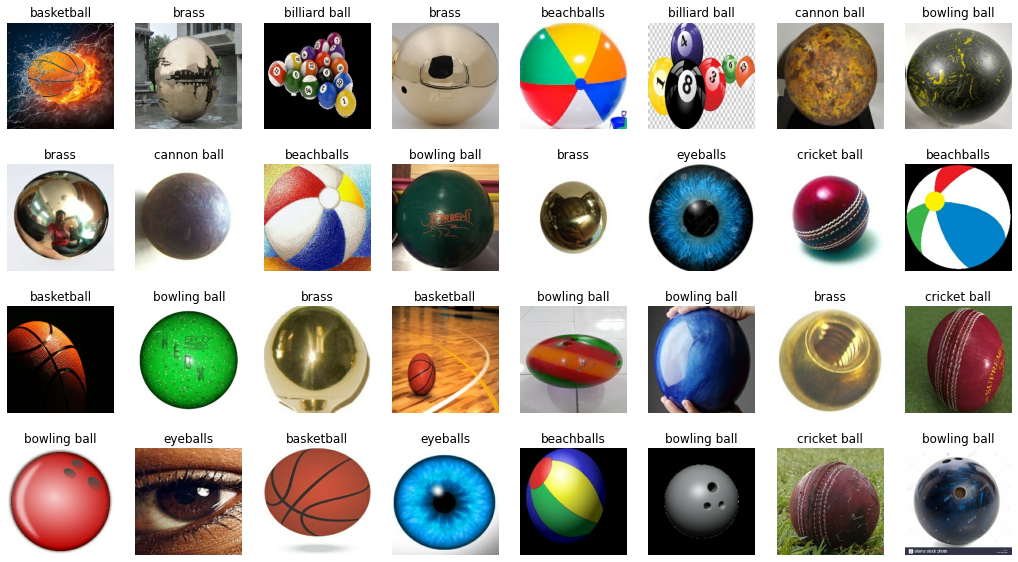

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(18, 10))

# Assumes dataset batch_size is at least 32.
num_rows = 4
num_cols = 8

# Here we use the take() method to retrieve just the first batch of data from the training portion of the dataset.
for data_batch, labels_batch in train_dataset.take(1): 
    
    # For the batch of images and the associated (one-hot encoded) labels, 
    # plot each of the images in the batch and the associated ground truth labels.
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(data_batch[i].numpy().astype("uint8"))
        truth_idx = np.nonzero(labels_batch[i].numpy())
        plt.title(class_names[truth_idx[0][0]])
        plt.axis("off")
        
# To loop through all batches in the dataset, use:
# for data_batch, labels_batch in train_dataset:

## 4 Train a Deep Neural Network Model

Here we define a generic Convolutional Neural Network (CNN) that will perform image classification to demonstrate the full processing pipeline in the context of using a local dataset that is managed using `BatchDataset` objects. The network below shows the typical pattern used to develop CNN architectures that contain multiple convoluiotnal blocks consisting of 2 or more Conv2D layers followed by a pooling layer, where the number of filters in block increases in the latter stages of the network.

In [ ]:
# Define the model.
def cnn_model(input_shape=(224, 224, 3), num_classes=10):
    
    #----------------------------------------------
    # Input layer and Conv Block 1: 32-32-MaxPool.
    #----------------------------------------------
    inputs = keras.Input(shape=input_shape)
    
    x = layers.Rescaling(1./255)(inputs)
    
    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 2: 64-64-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 3: 128-128-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #-----------------------------------
    # Conv Block 4: 256-256-MaxPool.
    #-----------------------------------
    x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2)(x)

    #------------------------------------
    # Flatten the convolutional features.
    #------------------------------------
    x = layers.Flatten()(x)
    
    # Fully connected layers.
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [ ]:
# Define the input shape.
input_shape = (data_config.IMG_HEIGHT, data_config.IMG_WIDTH, data_config.NUM_CHANNELS)

# Create the model.
model = cnn_model(input_shape=input_shape, num_classes=data_config.NUM_CLASSES)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                             

In [ ]:
# Compile the model.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=training_config.LEARNING_RATE),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# Create a model checkpoint callback to save the "best" model based on highest validation_accuracy.
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=training_config.CHECKPOINT_DIR,
                                                               save_weights_only=False,
                                                               monitor="val_accuracy",
                                                               mode="max",
                                                               save_best_only=True,
                                                              )

# Train the model.
training_results = model.fit(train_dataset,
                             epochs=training_config.EPOCHS,
                             validation_data=valid_dataset,
                             callbacks=model_checkpoint_callback,
                            )

Epoch 1/21
18/18 [==============================] - 10s 377ms/step - loss: 2.3150 - accuracy: 0.1609 - val_loss: 2.2078 - val_accuracy: 0.1950
Epoch 2/21
18/18 [==============================] - 6s 299ms/step - loss: 2.0248 - accuracy: 0.2889 - val_loss: 2.1302 - val_accuracy: 0.2400
Epoch 3/21
18/18 [==============================] - 6s 310ms/step - loss: 1.9027 - accuracy: 0.3244 - val_loss: 1.8894 - val_accuracy: 0.2850
Epoch 4/21
18/18 [==============================] - 6s 300ms/step - loss: 1.7271 - accuracy: 0.3813 - val_loss: 1.8371 - val_accuracy: 0.3650
Epoch 5/21
18/18 [==============================] - 4s 178ms/step - loss: 1.5172 - accuracy: 0.4720 - val_loss: 1.7072 - val_accuracy: 0.3550
Epoch 6/21
18/18 [==============================] - 6s 304ms/step - loss: 1.3967 - accuracy: 0.5227 - val_loss: 1.7502 - val_accuracy: 0.4350
Epoch 7/21
18/18 [==============================] - 6s 310ms/step - loss: 1.1101 - accuracy: 0.6178 - val_loss: 1.3491 - val_accuracy: 0.5650
Epoch

### 4.1 Plot Training Results

In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, training_config.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(2))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show(block=block_plot)
    plt.close()

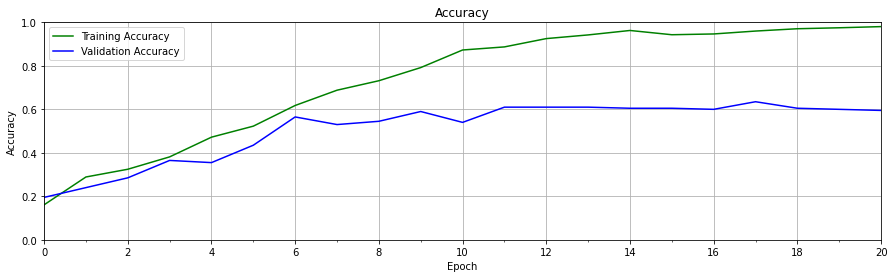

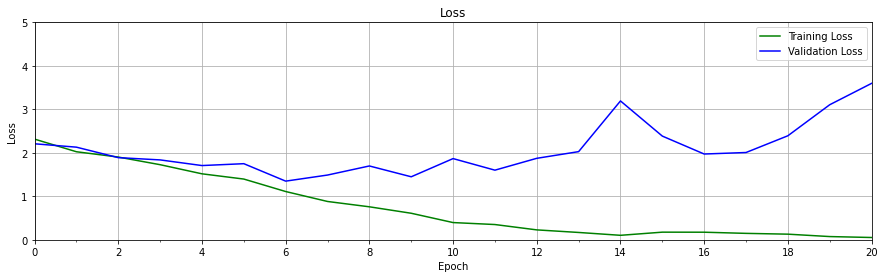

In [ ]:
# Retrieve training results.
train_loss = training_results.history["loss"]
train_acc  = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc  = training_results.history["val_accuracy"]
    
plot_results([ train_acc, valid_acc ], 
            ylabel="Accuracy",
            ylim = [0.0, 1.0],
            metric_name=["Training Accuracy", "Validation Accuracy"],
            color=["g", "b"])

plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            ylim = [0.0, 5.0],
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

## 5 Model Evaluation

In [ ]:
valid_loss, valid_acc = model.evaluate(valid_dataset)
print(f"Validation accuracy: {valid_acc:.3f}")

4/4 [==============================] - 0s 50ms/step - loss: 3.5970 - accuracy: 0.5950
Validation accuracy: 0.595


In [ ]:
def evaluate_model(dataset, checkpoint_dir=None):
    
    if not checkpoint_dir:
        checkpoint_dir = os.path.join(os.getcwd(),training_config.CHECKPOINT_DIR)
        
    # Load saved model.
    model = tf.keras.models.load_model(checkpoint_dir)
    
    num_matches = 0
    plt.figure(figsize=(17, 12))
    num_rows = 5
    num_cols = 6
    class_names = dataset.class_names
    
    # Retrieve a single batch.
    for data_batch, labels_batch in dataset.take(1):
        
        predictions = model.predict(data_batch)
        
        for idx in range(num_rows*num_cols):
            ax = plt.subplot(num_rows, num_cols, idx + 1)
            plt.axis("off")
            plt.imshow(data_batch[idx].numpy().astype("uint8"))

            pred_idx = tf.argmax(predictions[idx]).numpy()
            truth_idx = np.nonzero(labels_batch[idx].numpy())
            
            title = str(class_names[truth_idx[0][0]]) + " : " + str(class_names[pred_idx])
            title_obj = plt.title(title, fontdict={'fontsize':11})
            
            if pred_idx == truth_idx:
                num_matches += 1
                plt.setp(title_obj, color='g')
            else:
                plt.setp(title_obj, color='r')
                
            acc = num_matches/(idx+1)
        print("Prediction accuracy: ", int(100*acc)/100)
    
    return

Prediction accuracy:  0.56


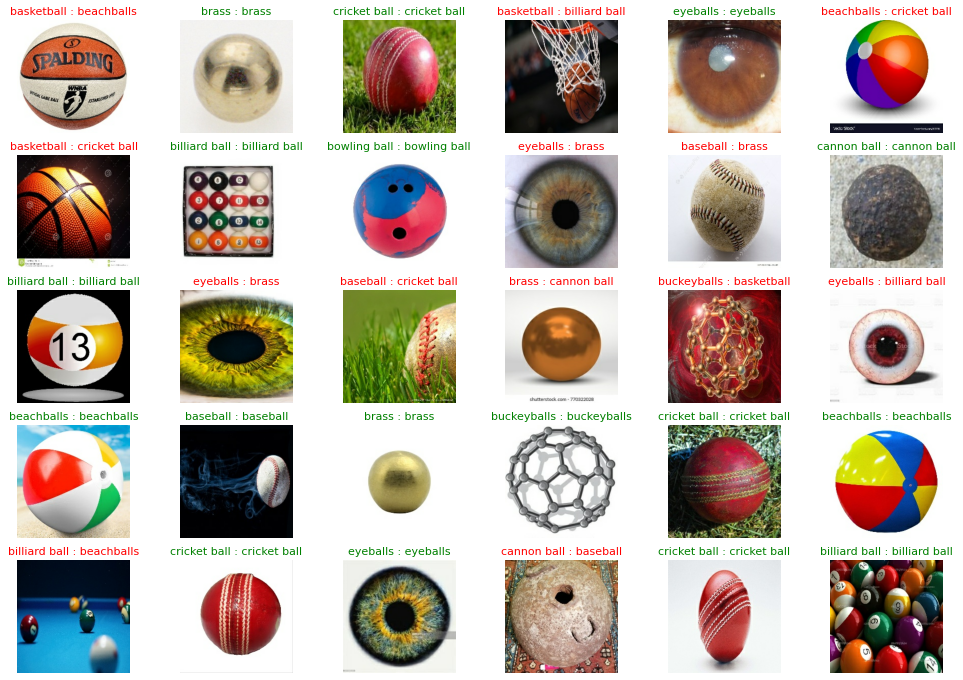

In [ ]:
evaluate_model(valid_dataset, training_config.CHECKPOINT_DIR)

## 6 Conclusion

In this notebook, we learned how to use `image_dataset_from_directory()` to read and process a dataset on the lcoal file system. The object created from this utility is a `BatchDataset` object which is a subclass of `tf.data.Dataset` which enables you to build complex and powerful input data processing pipelines. We will continue to work with `tf.data.Dataset` in future notebooks as we introduce other capabilities in this class.
